In [1]:
!pip install --quiet ONE-api
!pip install --quiet ibllib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.5/994.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.0/206.0 kB 14.5 MB/s eta 0

Data loading and Subject Selection

In [11]:
from one.api import ONE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from torch.utils.data import Dataset, DataLoader


ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

datasets = one.alyx.rest('datasets', 'list', tag='2021_Q1_IBL_et_al_Behaviour', name='_ibl_subjectTrials.table.pqt')
subjects = np.unique([d['file_records'][0]['relative_path'].split('/')[2] for d in datasets])

# Load in the subjectTrials table and sessionTrials table for the first subject
print(subjects)
subject = subjects[0]
subject_trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')
session_trials = one.load_aggregate('subjects', subject, '_ibl_subjectSessions.table')

# Add in lab, task_protocol, subject name information from the sessions table
if 'task_protocol' in subject_trials:
    subject_trials = subject_trials.drop('task_protocol', axis=1)
subject_trials = subject_trials.set_index('session').join(session_trials.drop('date', axis=1))

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"
['CSHL045' 'CSHL046' 'CSHL047' 'CSHL049' 'CSHL051' 'CSHL052' 'CSHL053'
 'CSHL054' 'CSHL055' 'CSHL058' 'CSHL059' 'CSHL060' 'CSHL_001' 'CSHL_002'
 'CSHL_003' 'CSHL_004' 'CSHL_005' 'CSHL_006' 'CSHL_007' 'CSHL_008'
 'CSHL_010' 'CSHL_012' 'CSHL_014' 'CSHL_015' 'CSH_ZAD_001' 'CSH_ZAD_002'
 'CSH_ZAD_003' 'CSH_ZAD_004' 'CSH_ZAD_005' 'CSH_ZAD_006' 'CSH_ZAD_007'
 'CSH_ZAD_010' 'CSH_ZAD_011' 'CSH_ZAD_017' 'CSH_ZAD_022' 'DY_001' 'DY_002'
 'DY_003' 'DY_005' 'DY_006' 'DY_007' 'DY_008' 'DY_009' 'DY_010' 'DY_011'
 'DY_013' 'DY_014' 'DY_015' 'IBL-T1' 'IBL-T2' 'IBL-T3' 'IBL-T4' 'IBL_001'
 'IBL_002' 'KS002' 'KS004' 'KS005' 'KS014' 'KS015' 'KS016' 'KS017' 'KS018'
 'KS019' 'KS020' 'KS021' 'KS022' 'KS023' 'KS024' 'KS025' 'NYU-01' 'NYU-02'
 'NYU-04' 'NYU-06' 'NYU-07' 'NYU-09' 'NYU-11' 'NYU-12' 'NYU-13' 'NYU-14'
 'NYU-20' 'SWC_001' 'SWC_013' 'SWC_014' 'SWC_015' 'SWC_017' 'SWC_018'
 'SWC_021' 'SWC_022' 'SWC_023' 'SWC_029' 'SWC_030' '

Feature Engineering

In [6]:
def extract_trial_features(trials_df):
    features = []

    for i in range(1, len(trials_df)):
        # Basic trial info
        trial_time = trials_df['stimOn_times'].iloc[i]
        choice = trials_df['choice'].iloc[i]
        correct = trials_df['feedbackType'].iloc[i] == 1

        # Reaction time features
        rt = trials_df['response_times'].iloc[i] - trials_df['stimOn_times'].iloc[i]
        rt_prev = trials_df['response_times'].iloc[i-1] - trials_df['stimOn_times'].iloc[i-1]

        # Inter-trial interval
        iti = trials_df['stimOn_times'].iloc[i] - trials_df['feedback_times'].iloc[i-1]

        # Performance history
        window_size = 10
        if i > window_size:
            recent_perf = np.mean(trials_df['feedbackType'].iloc[i-window_size:i] == 1)
        else:
            recent_perf = np.nan

        features.append({
            'trial_num': i,
            'reaction_time': rt,
            'reaction_time_diff': rt - rt_prev,
            'iti': iti,
            'correct': correct,
            'recent_performance': recent_perf,
            'choice_consistency': 1 if choice == trials_df['choice'].iloc[i-1] else 0,
            'trial_time': trial_time - trials_df['stimOn_times'].iloc[0]  # Session time
        })

    return pd.DataFrame(features).dropna()

# Proper usage with your data:
sess = subject_trials[subject_trials['task_protocol'].str.contains('biasedChoiceWorld')].index.unique()[0]
trials_df = subject_trials[subject_trials.index == sess].copy()

# Ensure we have required columns
required_cols = ['stimOn_times', 'response_times', 'feedbackType', 'choice', 'feedback_times']
assert all(col in trials_df.columns for col in required_cols), "Missing required columns"

features_df = extract_trial_features(trials_df)
features_df.head()

,trial_num,reaction_time,reaction_time_diff,iti,correct,recent_performance,choice_consistency,trial_time


In [7]:
# Check the raw trial data structure
print(f"Total trials: {len(trials_df)}")
print("\nColumns present:")
print(trials_df.columns.tolist())

# Check for missing values
print("\nMissing values per column:")
print(trials_df[['stimOn_times','response_times','choice','feedbackType','feedback_times']].isna().sum())

# Check first 5 rows
print("\nFirst 5 trials:")
print(trials_df.head())

Total trials: 682

Columns present:
['intervals_0', 'intervals_1', 'goCue_times', 'response_times', 'choice', 'stimOn_times', 'contrastLeft', 'contrastRight', 'feedback_times', 'feedbackType', 'rewardVolume', 'probabilityLeft', 'firstMovement_times', 'goCueTrigger_times', 'stimOnTrigger_times', 'stimOffTrigger_times', 'stimFreezeTrigger_times', 'stimOff_times', 'stimFreeze_times', 'phase', 'position', 'quiescence', 'protocol_number', 'session_start_time', 'lab', 'subject', 'number', 'task_protocol', 'projects']

Missing values per column:
stimOn_times      1
response_times    0
choice            0
feedbackType      0
feedback_times    0
dtype: int64

First 5 trials:
                                      intervals_0  intervals_1  goCue_times  \
session                                                                       
a4f7079b-d157-4de9-ba80-de9a98f35c8b       0.0000    10.582602       5.7094   
a4f7079b-d157-4de9-ba80-de9a98f35c8b      11.0663    14.771902      11.7101   
a4f7079b-

Visualization

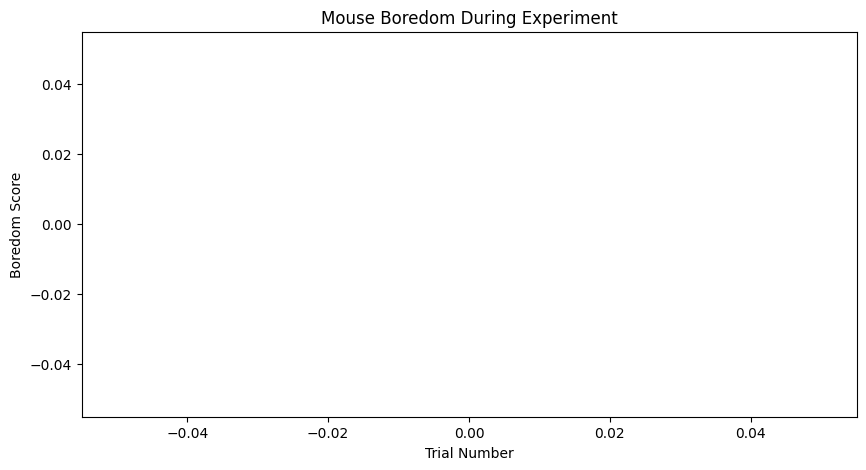

In [13]:
def calculate_boredom(features):

    # Calculate how bored the mouse is based on its behavior
    # Make all numbers on similar scale (0-1)
    rt_norm = (features['reaction_time'] - features['reaction_time'].min()) / (features['reaction_time'].max() - features['reaction_time'].min())

    time_norm = (features['iti'] - features['iti'].min()) / (features['iti'].max() - features['iti'].min())

    perf_norm = 1 - features['recent_performance']  # Lower performance = more bored

    # Combine them with weights
    boredom = 0.4*rt_norm + 0.3*time_norm + 0.3*perf_norm
    return boredom

# Calculate and plot boredom
if 'features_df' in locals():
  features_df['boredom'] = calculate_boredom(features_df)
  plt.figure(figsize=(10, 5))
  plt.plot(features_df['trial_num'], features_df['boredom'], color='red')
  plt.xlabel('Trial Number')
  plt.ylabel('Boredom Score')
  plt.title('Mouse Boredom During Experiment')
  plt.show()

I dont know why the features dataset was showing empty columns and also the graph is not getting plotted. I couldn't figure out why.